Library and general method initializations

In [1]:
from sklearn.datasets import load_files
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
from glob import glob
import random
import cv2
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD,Adagrad,Adam, Nadam
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt     
from keras.preprocessing import image    
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout, Flatten, Dense, Input
from keras.models import Sequential,Model,model_from_json
from sklearn.metrics import log_loss
from keras import optimizers
import math
import pickle
import os
import pandas as pd
import datetime
from keras.callbacks import EarlyStopping, Callback,ModelCheckpoint
from sklearn.model_selection import KFold 
from keras.regularizers import l1,l2,l1_l2
from keras.layers.noise import AlphaDropout

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        #clear_output(wait=False)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend(['train', 'test'], loc='upper left')
        plt.show();

def model_history(history):
  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'single_model.json'), 'w').write(json_string)

def read_model():
    model = model_from_json(open(os.path.join('cache', 'single_model.json')).read())
    return model

def create_submission(predictions, test_id, loss):
    print('Started building csv file')
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.insert(loc=0, column='img', value=test_id)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result.to_csv(subfile, index=False)
    print("successfully created submission")   
    
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def read_imc(path):
    img = cv2.imread(path)
    img_rows, img_cols=224,224
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized

def get_driver_data():
    dr = dict()
    clss = dict()
    path ='Data/driver_imgs_list.csv'
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

def load_train():
    driver_file=[]
    driver_target=[]
    driver_id=[]
    driver_file_id=[]
    driver_data, dr_class = get_driver_data()
    print('driver data and class sample',len(driver_data),len(dr_class))
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'Data', 'imgs', 'train', 'c' + str(j), '*.jpg')
        data = glob(path)
        for p in data:
            
            driver_file.append(read_imc(p))
            driver_target.append(j)
            base = os.path.basename(p)
            driver_file_id.append(base)
            driver_id.append(driver_data[base])
            
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return driver_file,driver_target,driver_file_id,driver_id,unique_drivers

def load_test():
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    for p in data:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))
        
    return driver_file,driver_id

def split_list(l,size):
    return [l[i*len(l) // size: (i+1)*len(l) // size] for i in range(size)]

def load_test_parts(part,splits):
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    test_chunks=split_list(data,splits)
    
    for p in test_chunks[part]:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))

    return driver_file,driver_id

def append_chunk(main, part):
    for p in part:
        main.append(p)
        
    return main

def print_sample(data,target):
    print ("X shape",data.shape) 
    print ("Y shape",target.shape)

    return None

def get_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
   
    for i in range(len(train_data)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
    del train_data
    del train_target
    del driver_id
    del driver_list
    data = np.array(data,dtype=np.uint8)
    target = np.array(target,dtype=np.uint8)
    return data, target

def data_split(data,target,test_size,driver_id,driver_list):
        random.shuffle(driver_list)
        test_split=test_size*len(driver_list)
        test_split=int(round(test_split))
       
        train_list=driver_list[test_split:]
        test_list=driver_list[:test_split]
        
        X_train,y_train = get_selected_drivers(data,target,driver_id,train_list)
        X_test,y_test = get_selected_drivers(data,target,driver_id,test_list)

        return X_train, X_test, y_train, y_test, test_list


    
img_rows=224
img_cols=224
img_channel=3  


Using TensorFlow backend.


Section solely used to split the train data into 3 parts( train, test, validation)

In [ ]:
# SECTION USED ONLY TO SPLIT DATA

cache_path= os.path.join('cache','train_224.dat')
if not os.path.isfile(cache_path):
    print('building train cache')
    train_files,train_targets,train_id, driver_id, unique_drivers = load_train()
    cache_data((train_files,train_targets,train_id, driver_id, unique_drivers),cache_path)
    print('train cache built')           
else:
    print('Restore train from cache')
    (train_files,train_targets,train_id, driver_id, unique_drivers)=restore_data(cache_path)

train_files=np.array(train_files,dtype=np.uint8)

train_files = train_files.reshape(train_files.shape[0], img_rows, img_cols,img_channel)

test_size=0.3
X_train, X_split, y_train, y_split,split_driver_list =data_split(train_files,train_targets,test_size,driver_id,unique_drivers)

del train_files
del train_targets

test_size=0.4

X_test, X_val, y_test, y_val,val_driver_list = data_split(X_split,y_split,test_size,driver_id,split_driver_list)

cache_path= os.path.join('cache','train_split_224.dat')
if not os.path.isfile(cache_path):
    print('building train cache')
    cache_data((X_train,y_train),cache_path)
    print('train cache built')           

    
cache_path= os.path.join('cache','val_split_224.dat')
if not os.path.isfile(cache_path):
    print('building val cache')
    cache_data((X_val,y_val),cache_path)
    print('val cache built')           

    
cache_path= os.path.join('cache','test_split_224.dat')
if not os.path.isfile(cache_path):
    print('building test cache')
    cache_data((X_test,y_test),cache_path)
    print('test cache built')           
    


Method that reads the test chunk and normalizes it

In [ ]:

def get_test_predictions(model):

    cache_path= os.path.join('cache','test_split_224.dat')    
    if os.path.isfile(cache_path):
        print('Restore test split from cache')
        (X_test,y_test)=restore_data(cache_path)
    else:
        print('Test split data cache is empty')

    X_test=np.array(X_test,dtype=np.uint8)
    y_test=np.array(y_test,dtype=np.uint8)
    y_test=np_utils.to_categorical(y_test,10)   

    X_test = X_test.astype('float32')
    X_test/=255
    predictions=model.predict(X_test, verbose=0)
    score=log_loss(y_test,predictions)
    print('Score log_loss: ', score)
    
    return score   

The parameter initializations

In [ ]:
batch_size=32
epochs=15

MAIN SECTION: Reading, preprocessing, training and testing section

Restore train split from cache
Restore val split from cache
Epoch 00001: val_loss improved from inf to 2.23107, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00002: val_loss improved from 2.23107 to 2.13158, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00003: val_loss improved from 2.13158 to 1.93225, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00004: val_loss improved from 1.93225 to 1.59040, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00005: val_loss improved from 1.59040 to 1.20057, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00006: val_loss improved from 1.20057 to 0.91013, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00007: val_loss improved from 0.91013 to 0.75790, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00008: val_loss improved from 0.75790 to 0.68605, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00009: val_loss improved from 0.68605 to 0.65009, saving model to 

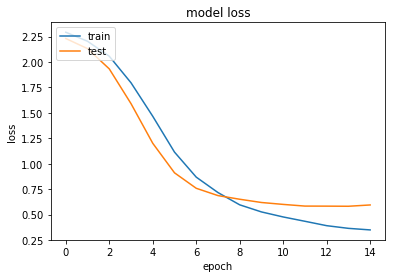

Restore test split from cache
Score log_loss:  0.619327433659


In [2]:
cache_path= os.path.join('cache','train_split_224.dat')   
if os.path.isfile(cache_path):
    print('Restore train split from cache')
    (X_train,y_train)=restore_data(cache_path)
else:
    print('train split data cache is empty')
    
X_train=np.array(X_train,dtype=np.uint8)
y_train=np.array(y_train,dtype=np.uint8)
y_train=np_utils.to_categorical(y_train,10)
    
    
cache_path= os.path.join('cache','val_split_224.dat')   
if os.path.isfile(cache_path):
    print('Restore val split from cache')
    (X_val,y_val)=restore_data(cache_path)
else:
    print('val split data cache is empty')
    
X_val=np.array(X_val,dtype=np.uint8)
y_val=np.array(y_val,dtype=np.uint8)
y_val=np_utils.to_categorical(y_val,10)   


train_datagen=ImageDataGenerator(
   rescale=1./255,
   zoom_range=0.4,
   width_shift_range=0.4,
   height_shift_range=0.4
    )

val_datagen=ImageDataGenerator(
   rescale=1./255
    )


base_model = InceptionResNetV2(input_shape=(224,224,3),weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0009, momentum=0.7), loss='categorical_crossentropy')


train_datagen.fit(X_train)
val_datagen.fit(X_val)


checkpointer = ModelCheckpoint(filepath='cache/weights_single_model.hdf5', 
                               verbose=1, save_best_only=True)


history=model.fit_generator(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                            validation_data=val_datagen.flow(X_val,y_val),
                    steps_per_epoch=len(X_train)//batch_size,validation_steps=len(X_val)//batch_size,epochs=epochs,
                            callbacks=[checkpointer],verbose=0)
save_model(model)
model_history(history)


get_test_predictions(model)
   

Just some test results with different models

In [ ]:
Some results:

Global Average pooling Xception Score log_loss:  2.2960430687
Global Max pooling Xception Score log_loss:  2.29670835679
Global Average pooling resnet Score log_loss:  5.34713518405
Global Average pooling vgg19 Score log_loss:  31.0368328663
Global Average pooling inceptionv3 Score log_loss:  1.95701219222
Global Max pooling inceptionv3 Score log_loss:  30.0924949305
Global Average pooling vgg16 Score log_loss:  30.9338345272
Global Max pooling vgg16 Score log_loss:  30.6248395097
Global Average pooling mobilenet Score log_loss:  2.47601450317
Dense  Inceptionv3 Score log_loss:  1.37379334373

Section that loads the model and its weights

In [2]:
model = read_model()
model.load_weights('cache/weights_single_model.hdf5')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
print('read and compiled model')
    

read and compiled model


Section that loads and splits the test dataset into 5 parts. It is also used to build the test submission csv file

In [3]:
score=get_test_predictions(model)

predictions=[]
test_ids=[]
test_splits=5
for x in range(test_splits):
    print('iteration: ',x)
    y=x+1
    cache_path= os.path.join('cache','test_224_part'+str(y)+'.dat')

    if not os.path.isfile(cache_path):
        print('building test cache')
        test_files,test_id = load_test_parts(x,test_splits)
        cache_data((test_files,test_id),cache_path)
        print('test cache built')
    else:
        print('Restore test from cache')
        (test_files,test_id)=restore_data(cache_path)
    
    test_files=np.array(test_files,dtype=np.uint8)    
    test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
    test_files = test_files.astype('float32')
    test_files/=255
    
    prediction=model.predict(test_files,  batch_size=batch_size)
    predictions=append_chunk(predictions,prediction)
    test_ids=append_chunk(test_ids,test_id)
    del test_files
    print('prediction length ',len(predictions))
    print('test id length ',len(test_ids))

print('prediction length ',len(predictions))
create_submission(predictions,test_ids,score)    

iteration:  0
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  15945
test id length  15945
iteration:  1
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  31890
test id length  31890
iteration:  2
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  47835
test id length  47835
iteration:  3
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  63780
test id length  63780
iteration:  4
Restore test from cache
test length (15946, 224, 224, 3)
prediction length  79726
test id length  79726
prediction length  79726
Started building csv file
successfully created submission
